In [1]:
!pip install gdown
!gdown --id 1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv
From (redirected): https://drive.google.com/uc?id=1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv&confirm=t&uuid=cceb4c27-ffcf-41e2-9446-f2e3c3757d7d
To: /kaggle/working/Dataset.zip
100%|██████████████████████████████████████| 2.76G/2.76G [00:32<00:00, 84.6MB/s]


In [ ]:
!unzip '/kaggle/working/Dataset.zip' -d '/kaggle/working/'

In [3]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
print("Num CPU Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPU Available:  1
Num GPUs Available:  1


# Model

In [6]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
mobilenet_model.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [7]:
last_output = mobilenet_model.get_layer('out_relu').output

pre_trained_model = tf.keras.Model(mobilenet_model.input, last_output)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [8]:
def model_creator(dense_num):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten(name = 'flatten')(pre_trained_model.output)
  # Add a fully connected layer with 4 hidden units and ReLU activation
  x = tf.keras.layers.Dense(dense_num, activation='relu', name = 'dense_first')(x)
  # Add a dropout rate of 0.25
  x = tf.keras.layers.Dropout(0.25)(x)                  
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           

  # Append the dense network to the base model
  model = tf.keras.Model(pre_trained_model.input, x) 

  return model

# Print the model summary. See your dense network connected at the end.
model = model_creator(4)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# Dataset

In [9]:
TRAINING_DIR = "/kaggle/working/train"
VALIDATION_DIR = "/kaggle/working/validation"
TEST_DIR = '/kaggle/working/test'

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

Found 7726 images belonging to 2 classes.
Found 966 images belonging to 2 classes.
Found 966 images belonging to 2 classes.


# Find Optimal LR

In [10]:
# finding appropreate learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10 ** (epoch/20)
)

model.compile(optimizer='adam' , loss='binary_crossentropy')

In [11]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    callbacks=[lr_schedule],
                    epochs = 100,
                    verbose = 1)

Epoch 1/100
242/242 [==============================] - 144s 557ms/step - loss: 0.8341 - val_loss: 0.8137 - lr: 1.0000e-08
Epoch 2/100
242/242 [==============================] - 132s 542ms/step - loss: 0.8321 - val_loss: 0.8077 - lr: 1.1220e-08
Epoch 3/100
242/242 [==============================] - 128s 527ms/step - loss: 0.8214 - val_loss: 0.8013 - lr: 1.2589e-08
Epoch 4/100
242/242 [==============================] - 129s 532ms/step - loss: 0.8148 - val_loss: 0.7941 - lr: 1.4125e-08
Epoch 5/100
242/242 [==============================] - 128s 529ms/step - loss: 0.8123 - val_loss: 0.7864 - lr: 1.5849e-08
Epoch 6/100
242/242 [==============================] - 130s 535ms/step - loss: 0.8041 - val_loss: 0.7786 - lr: 1.7783e-08
Epoch 7/100
242/242 [==============================] - 128s 529ms/step - loss: 0.7955 - val_loss: 0.7701 - lr: 1.9953e-08
Epoch 8/100
242/242 [==============================] - 128s 528ms/step - loss: 0.7901 - val_loss: 0.7614 - lr: 2.2387e-08
Epoch 9/100
242/242 [===

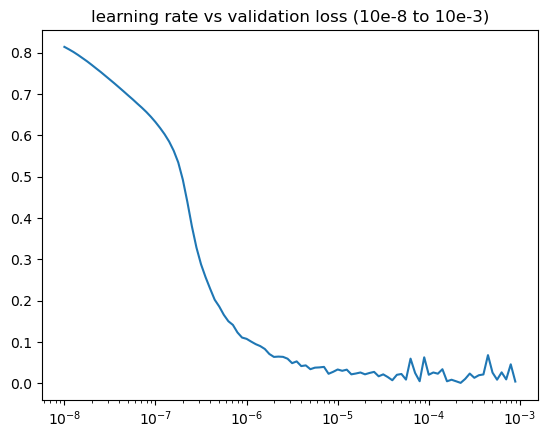

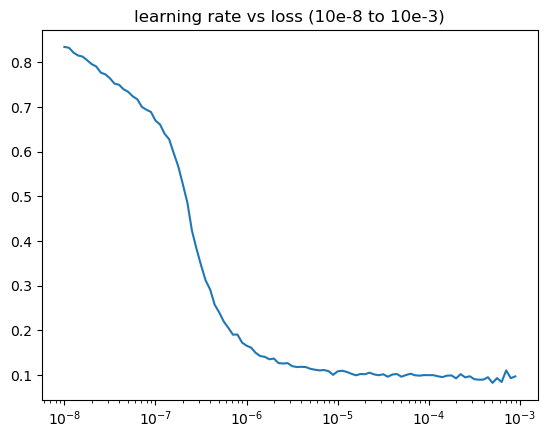

<Figure size 640x480 with 0 Axes>

In [12]:
#plot learning rate schedule

lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs , history.history['val_loss'])
plt.title('learning rate vs validation loss (10e-8 to 10e-3)')
plt.figure()
plt.semilogx(lrs , history.history['loss'])
plt.title('learning rate vs loss (10e-8 to 10e-3)')
plt.figure()

plt.show()

# Train

In [13]:
# Re-define the model to train with the optimal learning rate

model = model_creator(4)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6) , 
                loss='binary_crossentropy', metrics = ['acc'])

In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=50,
                    callbacks = [early_stopping_cb],
                    verbose = 1)

Epoch 1/50
242/242 [==============================] - 135s 540ms/step - loss: 0.6826 - acc: 0.5518 - val_loss: 0.5509 - val_acc: 0.7267
Epoch 2/50
242/242 [==============================] - 131s 542ms/step - loss: 0.4545 - acc: 0.7824 - val_loss: 0.2691 - val_acc: 0.9213
Epoch 3/50
242/242 [==============================] - 129s 532ms/step - loss: 0.3019 - acc: 0.8713 - val_loss: 0.1614 - val_acc: 0.9565
Epoch 4/50
242/242 [==============================] - 129s 534ms/step - loss: 0.2072 - acc: 0.9139 - val_loss: 0.0964 - val_acc: 0.9720
Epoch 5/50
242/242 [==============================] - 130s 535ms/step - loss: 0.1496 - acc: 0.9366 - val_loss: 0.0782 - val_acc: 0.9762
Epoch 6/50
242/242 [==============================] - 134s 553ms/step - loss: 0.1239 - acc: 0.9465 - val_loss: 0.0681 - val_acc: 0.9793
Epoch 7/50
242/242 [==============================] - 132s 547ms/step - loss: 0.1125 - acc: 0.9495 - val_loss: 0.0649 - val_acc: 0.9783
Epoch 8/50
242/242 [============================

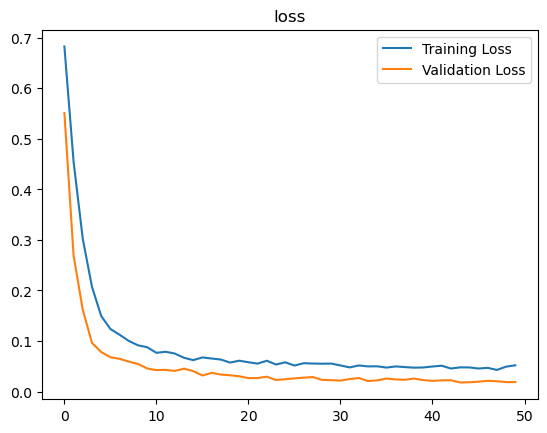

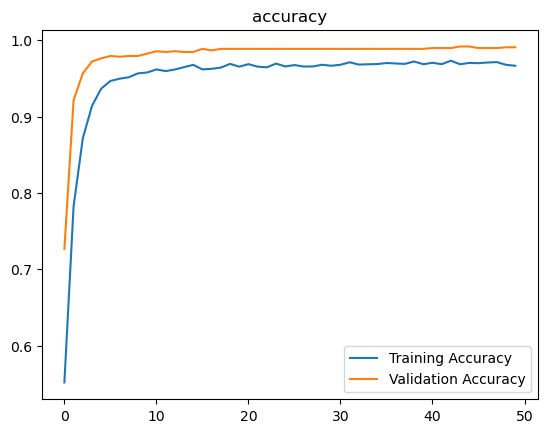

In [17]:
#plot acc and loss

model.save('/kaggle/working/xception.h5')

epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['loss'], label='Training Loss')
plt.plot(epochs , history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()

plt.figure()

plt.plot(epochs , history.history['acc'], label='Training Accuracy')
plt.plot(epochs , history.history['val_acc'], label='Validation Accuracy')
plt.title('accuracy')
plt.legend()

plt.show()

# Statistics

In [18]:
test_generator.class_indices

{'covid': 0, 'normal': 1}

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5) , 
                loss='binary_crossentropy', metrics = ['acc',
                                                      tf.keras.metrics.AUC(),
                                                      tf.keras.metrics.Precision(),
                                                      tf.keras.metrics.Recall(),
                                                      tf.keras.metrics.TruePositives(),
                                                      tf.keras.metrics.TrueNegatives(),
                                                      tf.keras.metrics.FalsePositives(),
                                                      tf.keras.metrics.FalseNegatives()])

In [20]:
a = model.evaluate(test_generator)

31/31 [==============================] - 8s 199ms/step - loss: 0.0141 - acc: 0.9959 - auc: 1.0000 - precision: 0.9924 - recall: 1.0000 - true_positives: 522.0000 - true_negatives: 440.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00


In [21]:
conf_mx = [[a[6], a[7]],[a[8], a[5]]]
mx = np.array(conf_mx)
fscore = 2*a[3]*a[4]/(a[3]+a[4])
spc = mx[0, 0] * 1.0 / (mx[0, 0] + mx[0, 1])
sen = mx[1,1] * 1.0 / (mx[1,1] + mx[1,0])

print('accuracy:',np.round(a[1]*100,2),'%')
print('precision:',np.round(a[3]*100,2),'%')
print('recall:',np.round(a[4]*100,2),'%')
print('Sensitivity:',np.round(sen*100,2),'%')
print('Specificity:',np.round(spc*100,2),'%')
print('f1-score:',np.round(fscore*100,2),'%')
print('AUC:',np.round(a[2]*100,2),'%')

accuracy: 99.59 %
precision: 99.24 %
recall: 100.0 %
Sensitivity: 100.0 %
Specificity: 99.1 %
f1-score: 99.62 %
AUC: 100.0 %
